In [477]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [482]:
import matplotlib.pyplot as plt
import steady_state as ss
import numpy as np

standard_properties = {
  "yC": 0.4,
  "yWt": 0.05,
  "yA": 1e-7,
  "yWvInletMin": 1e-7,
  "crit_volfrac": 0.8,
  "tau_d": 1.0,
  "tau_f": 1.0,
  "conduit_radius": 50,
  "T_chamber": 1000,
  "c_v_magma": 3e3,
  "rho0_magma": 2.6e3,
  "K_magma": 10e9,
  "p0_magma": 5e6,
  "solubility_k": 5e-6,
  "solubility_n": 0.5,
  "fragsmooth_scale": 0.01,
}

# Set 1D mesh
x = np.linspace(-2150, -150, 1000)
# Wrap mesh to quail dimensions
x_quail = np.expand_dims(x, axis=(1, 2))
# Desired inputs
p_vent = 1e5
# u_inlet = 1
p_inlet = 100e6

f = ss.SteadyState(x, p_vent, p_inlet, input_type="p",
  override_properties=standard_properties
)

p, h, y, yF = f(x, "phy")
U1 = f(x_quail, "quail")

# Figure 1: p, h, y, yF native
plt.figure(figsize=(14,6))
plt.subplot(1,4,1)
plt.plot(x, p)
plt.ylabel("p / Pa")
plt.subplot(1,4,2)
plt.plot(x, h)
plt.ylabel("h / (J/kg)")
plt.subplot(1,4,3)
plt.plot(x, y)
plt.ylabel("Exsolved water mass fraction")
plt.subplot(1,4,4)
plt.plot(x, yF)
plt.ylabel("Fraction of total mass as fragmented magma")
for i in range(4):
  plt.subplot(1,4,1+i)
  plt.xlabel(f"x (m)")

# Figure 2: quail conserved variables format
plt.figure(figsize=(14,6))
for i in range (8): 
  plt.subplot(3,3,i+1)
  plt.plot(x, U1[...,i])
  plt.xlabel(f"x (m)")
  plt.ylabel(f"U[...,{i}]")

plt.show()

## Solve ODE in pressure coordinates

pcoord: 0.30515 s
xcoord: 1.08622 s


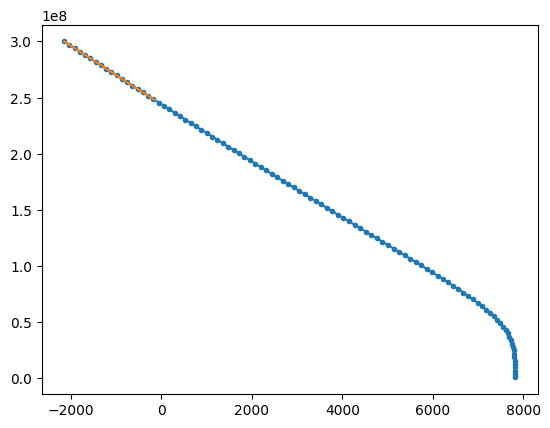

In [124]:
''' Compare backends '''

from time import perf_counter

# Run p-coordinate system solver, interpolate in pressure
t0 = perf_counter()
funcs = f.solve_pcoord_system(300e6, 2016.284047959758)
p_range = np.linspace(*funcs["range(p)"], 100)
x_range = funcs["x(p)"](p_range).ravel()
hyy_range = funcs["hyy(p)"](p_range)
t1 = perf_counter()
plt.plot(x_range, p_range, '.-')


# Run x-coordinate system solver
t2 = perf_counter()
_x, _phy, _ = f.solve_ssIVP(300e6, 2016.284047959758)
t3 = perf_counter()
plt.plot(_x, _phy[0,...])

print(f"pcoord: {t1 - t0:.5f} s")
print(f"xcoord: {t3 - t2:.5f} s")

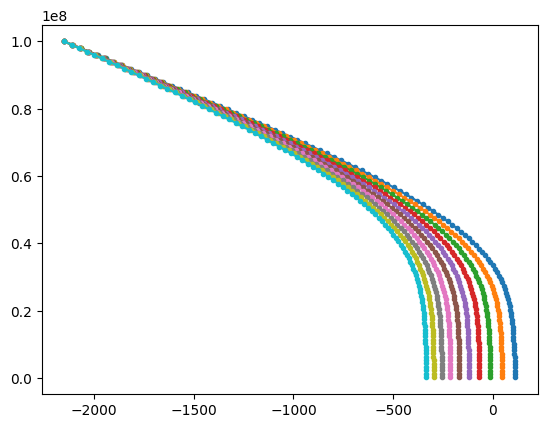

In [247]:
''' Try range of mass fluxes '''
j0_range = np.linspace(1500, 2500, 10)

for j0 in j0_range:
  funcs = f.solve_pcoord_system(100e6, j0)
  p_range = np.linspace(*funcs["range(p)"], 100)
  x_range = funcs["x(p)"](p_range).ravel()
  hyy_range = funcs["hyy(p)"](p_range)
  plt.plot(x_range, p_range, '.-')


In [ ]:
hyy

In [267]:
hyy0m = hyy_range.copy()
x0m = x_range.copy()

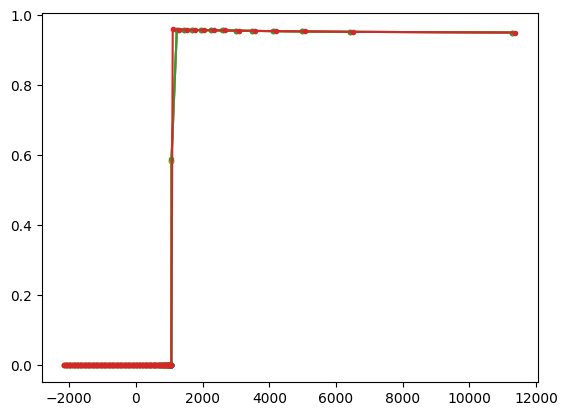

In [268]:
state_idx = 2
plt.plot(x0m, hyy0m[state_idx,...], '.-')
plt.plot(x1m, hyy1m[state_idx,...], '.-')
plt.plot(x10m, hyy10m[state_idx,...], '.-')
plt.plot(x100m, hyy100m[state_idx,...], '.-')

Text(0, 0.5, 'x')

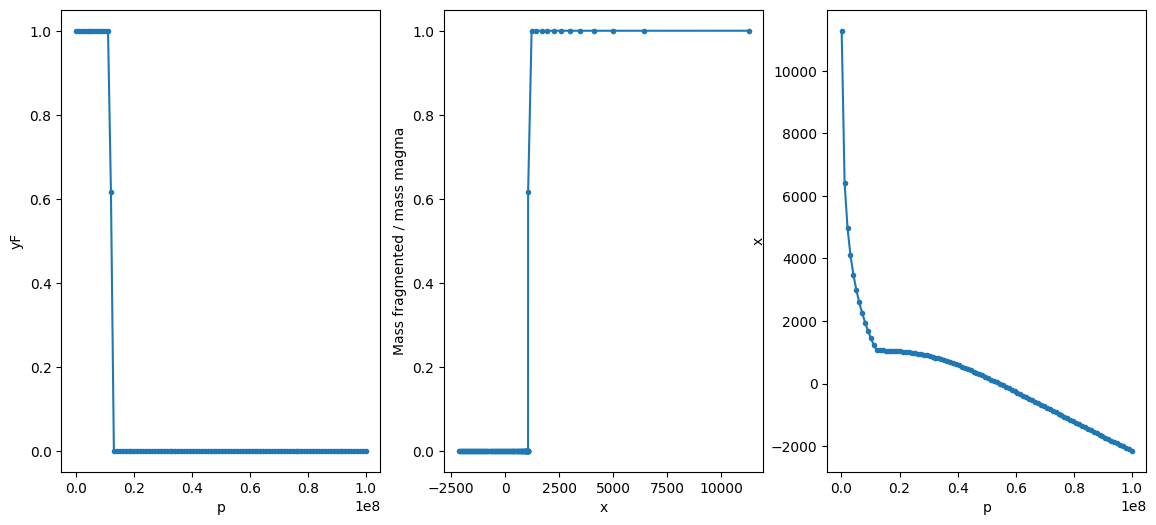

In [271]:
# Check fragmented yF
# funcs = f.solve_pcoord_system(100e6, 1348)
funcs = f.solve_pcoord_system(100e6, 500)
p_range = np.linspace(*funcs["range(p)"], 100)
x_range = funcs["x(p)"](p_range).ravel()
hyy_range = funcs["hyy(p)"](p_range)
# plt.plot(x_range, p_range, '.-')
plt.figure(figsize=(14,6))
plt.subplot(1,3,1)
plt.plot(p_range, hyy_range[2,...]/(1-f.yA-hyy_range[1,...]), '.-')
plt.xlabel("p")
plt.ylabel("yF")
plt.subplot(1,3,2)
plt.plot(x_range, hyy_range[2,...]/(1-f.yA-hyy_range[1,...]), '.-')
plt.xlabel("x")
plt.ylabel("Mass fragmented / mass magma")

plt.subplot(1,3,3)
plt.plot(p_range, x_range, '.-')
plt.xlabel("p")
plt.ylabel("x")


In [294]:
f.smoother(-0.1, _scale)

array(0.5)

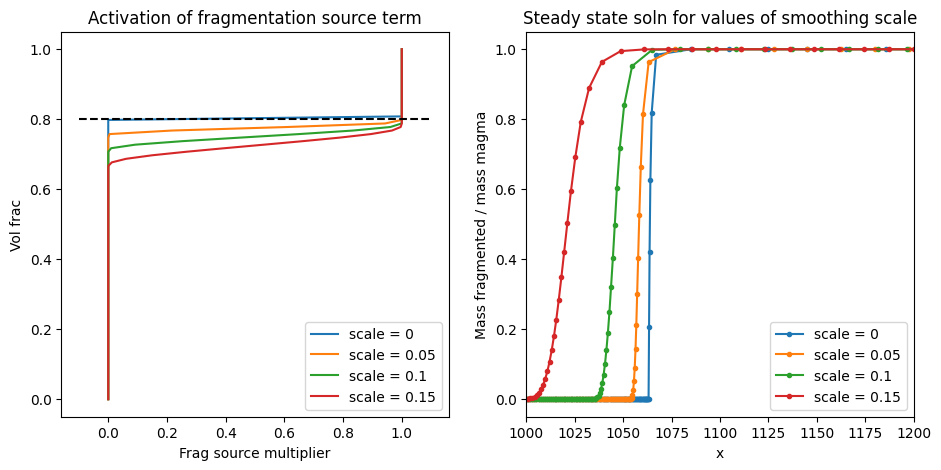

In [449]:
# Parametric
scale_range = [0, 0.05, 0.1, 0.15]

plt.figure(figsize=(11,5))

plt.subplot(1,2,1)
volfrac_range = np.linspace(0,1,100)
for _scale in scale_range:
  nonzero_scale = _scale if _scale > 0 else 0.0001
  plt.plot(
           f.smoother(volfrac_range - f.crit_volfrac, nonzero_scale),
           volfrac_range)
plt.title("Activation of fragmentation source term")
plt.xlabel("Frag source multiplier")
plt.ylabel("Vol frac")
plt.plot([-.1, 1.1], f.crit_volfrac * np.ones((2,1)), 'k--')
plt.legend([f"scale = {val}" for val in scale_range])

plt.subplot(1,2,2)
for _scale in scale_range:
  funcs = f.solve_pcoord_system(100e6, 500, tauf_scale=_scale)
  # Set independent pressure sampling range
  p_range = np.linspace(*funcs["range(p)"], 1000)
  x_range = funcs["x(p)"](p_range).ravel()
  hyy_range = funcs["hyy(p)"](p_range)

  plt.plot(x_range, hyy_range[2,...]/(1-f.yA-hyy_range[1,...]), '.-')
  plt.xlabel("x")
  plt.ylabel("Mass fragmented / mass magma")
  plt.xlim(1000,1200)
  plt.title("Steady state soln for values of smoothing scale")
plt.legend([f"scale = {val}" for val in scale_range])


### Projection test

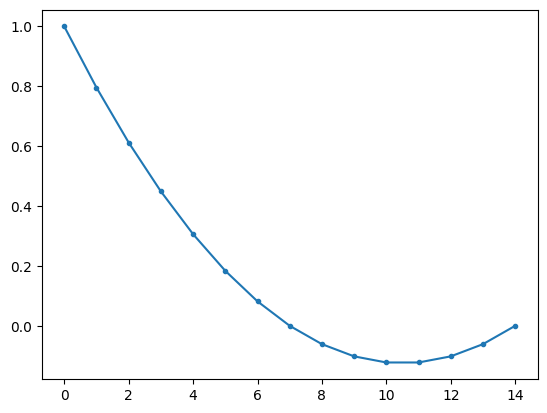

In [466]:
''' From DG_core.ipynb, modified '''

import scipy

# Element order (Gauss points are hard coded)
order = 2
# Set DG number of degrees of freedom
nb = order + 1
nq = nb

# Compute max stretched mesh
# x_min = x_range.min()
# x_max = x_range.max()
x_min = 800
x_max = 1400
ne = 600
# f.x_mesh = np.linspace(x_min, x_max, ne)

# Fill nodal coordinates, face coordinates, reference element coordinates
x_faces = np.linspace(x_min, x_max, ne + 1)
x_nodes_ref = np.linspace(-1.0, 1.0, nb)
x_nodes = np.empty((ne, nb,))
for i in range(ne):
  x_nodes[i,:] = np.linspace(x_faces[i], x_faces[i+1], nb)
# Fill quadrature coordinates (for order=2)
x_gauss_ref = np.array([-np.sqrt(0.6), 0, np.sqrt(0.6)])
w_gauss_ref = np.array([5/9, 8/9, 5/9])
# Fill (physical) quadrature point locations and weights
x_quad = np.empty((ne, nb,))
w_quad = np.empty((ne, nb,))
geomjac = np.empty((ne,))
for i in range(ne):
  # Apply affine mapping from [-1, 1] -> [x_faces[i], x_faces[i+1]]
  dx = x_faces[i+1] - x_faces[i]
  x_quad[i,:] = (x_faces[i] + x_faces[i+1]) / 2 + (dx / 2) * x_gauss_ref
  # Multiply quadrature weights with geom jacobian
  w_quad[i,:] = (dx / 2) * w_gauss_ref
  geomjac[i] = dx

# Define linear mapping from nodal points to quadrature points (basis_val in quail)
basis_val_map = np.empty((nq, nb))
basis_refgrad_map = np.empty((nq, nb, 1))
for i in range(nb):
  # Create one-hot vector representing nodal values of nodal polynomial
  one_hot = np.zeros((nb,))
  one_hot[i] = 1.0
  # Construct polynomial in scipy convention (monomial basis) on reference nodes
  _loc_poly = scipy.interpolate.lagrange(x_nodes_ref, one_hot)
  # Compute basis map (nodal value |-> value at quad point)
  basis_val_map[:,i] = _loc_poly(x_gauss_ref)
  # Compute basis reference-gradient map (nodal value |-> reference gradient at quad point)
  basis_refgrad_map[:,i,0] = _loc_poly.deriv()(x_gauss_ref)
# Compute physical-space gradient map (ne, nq, nb, 1)
basis_physgrad_map = np.einsum("i, jkl -> ijkl", 2.0 / geomjac, basis_refgrad_map)

# Local reference mass matrix (phi * phi)
M_loc = np.einsum("ki, kj, k -> ij", basis_val_map, basis_val_map, w_gauss_ref)
# Inverse mass matrix assembly (ne, nb, nq)
M_inv = np.einsum("i, jk -> ijk", 2.0 / geomjac, np.linalg.inv(M_loc))

# L2 Projection operator, used to compute 
#   projected = np.einsum("imk, ijl, jk, ij -> iml", M_inv, f_quad, basis_val_map, w_quad)
projection_op = np.einsum("imk, jk, ij -> imj", M_inv, basis_val_map, w_quad)

# Construct transfer operator sending nodal values to linearly spaced interval points
n_interp = 15
x_interp_ref = np.linspace(-1, 1, n_interp)
transfer_map = np.zeros((x_interp_ref.size, nb))
for i in range(nb):
  # Create one-hot vector representing nodal values of nodal polynomial
  one_hot = np.zeros((nb,))
  one_hot[i] = 1.0
  # Construct polynomial in scipy convention (monomial basis) on reference nodes
  _loc_poly = scipy.interpolate.lagrange(x_nodes_ref, one_hot)
  # Compute basis map (nodal value |-> value at quad point)
  transfer_map[:,i] = _loc_poly(x_interp_ref)
# Construct interp mesh (for plotting)
x_interp = np.zeros((ne, x_interp_ref.size))
for i in range(ne):
  # Apply affine mapping from [-1, 1] -> [x_faces[i], x_faces[i+1]]
  dx = x_faces[i+1] - x_faces[i]
  x_interp[i,:] = (x_faces[i] + x_faces[i+1]) / 2 + (dx / 2) * x_interp_ref
# Show one column of transfer map
plt.plot(transfer_map[:,0], '.-')


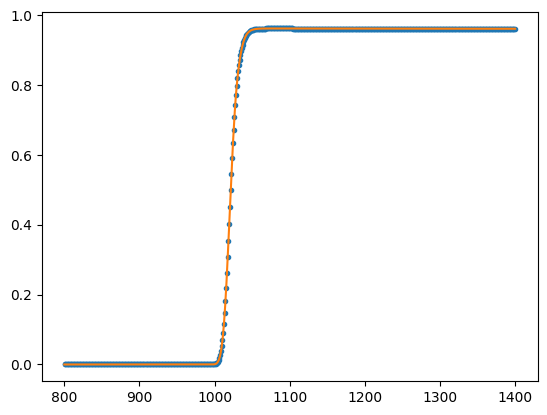

In [467]:
# Test for one set of parameters: evaluate vectorized function f at quad points

# Pressure-dependent vector solution
pcoord_sys = f.solve_pcoord_system(100e6, 500, tauf_scale=_scale)
_out_fn = pcoord_sys["hyy(p)"]
_x_fn = pcoord_sys["x(p)"]
# Evaluate p at spatial points
_p_range = np.linspace(*pcoord_sys["range(p)"], 10000)[::-1]
p_quad = scipy.interpolate.pchip_interpolate(_x_fn(_p_range).ravel(), _p_range, x_quad)

# Evaluate hyy portion of solution at p(x)
h_quad = np.zeros_like(x_quad)
yW_quad = np.zeros_like(x_quad)
yF_quad = np.zeros_like(x_quad)
h_quad.ravel()[:], yW_quad.ravel()[:], yF_quad.ravel()[:] = _out_fn(p_quad.ravel())

# Test: plot element-averaged yF against yF at each quadrature point
plt.plot(x_quad[:,1].ravel(), np.einsum("ij, jk, ij -> ik",
                                        yF_quad,
                                        basis_val_map,
                                        w_quad).sum(axis=1)/dx, '.') 
plt.plot(x_quad.ravel(), yF_quad[:,:].ravel())

Text(0.5, 1.0, 'Piecewise parabolic representation of yF from L2 projection')

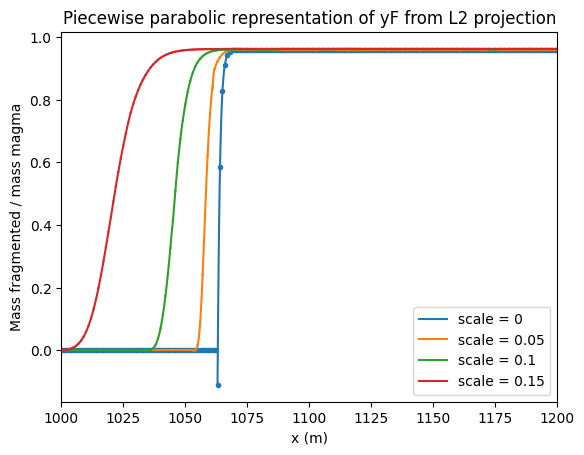

In [469]:
''' Compare L2 projections '''

scale_range = [0, 0.05, 0.1, 0.15]
# Select color palette for lines
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Plot dummy lines for legend top
for scale_idx, _ in enumerate(scale_range):
  plt.plot(x_interp.ravel()[0], 0, '-', color=colors[scale_idx])

for scale_idx, _scale in enumerate(scale_range):
  # Compute pressure-dependent vector solution
  pcoord_sys = f.solve_pcoord_system(100e6, 500, tauf_scale=_scale)

  # Evaluate p at quadrature points
  _p_range = np.linspace(*pcoord_sys["range(p)"], 20000)[::-1]
  p_quad = scipy.interpolate.pchip_interpolate(pcoord_sys["x(p)"](_p_range).ravel(), _p_range, x_quad)
  # Evaluate hyy portion of solution at p(x)
  h_quad = np.zeros_like(x_quad)
  yW_quad = np.zeros_like(x_quad)
  yF_quad = np.zeros_like(x_quad)
  h_quad.ravel()[:], yW_quad.ravel()[:], yF_quad.ravel()[:] = \
    pcoord_sys["hyy(p)"](p_quad.ravel())

  # Compute nodal values through L2 projection from values of yF at quad points
  projected = np.einsum("imj, ij... -> im...", projection_op, yF_quad)
  # Apply node-to-interp-points transfer operator
  vals_interp = np.einsum("km, im... -> ik...", transfer_map, projected)

  # Plot line for each element
  for ie in range(x_interp.shape[0]):
    plt.plot(x_interp[ie,:], vals_interp[ie,:,...], '-', color=colors[scale_idx])
  if scale_idx == 0:
    # Show nodes
    plt.plot(x_interp[:,0], vals_interp[:,0,...], '.', color=colors[scale_idx])
plt.xlim(1000,1200)
plt.xlabel("x (m)")
plt.ylabel("Mass fragmented / mass magma")
plt.legend([f"scale = {val}" for val in scale_range])
plt.title("Piecewise parabolic representation of yF from L2 projection")

In [471]:
vals_interp.max()

0.9624161074938496

## Projection test for dx = 0.5

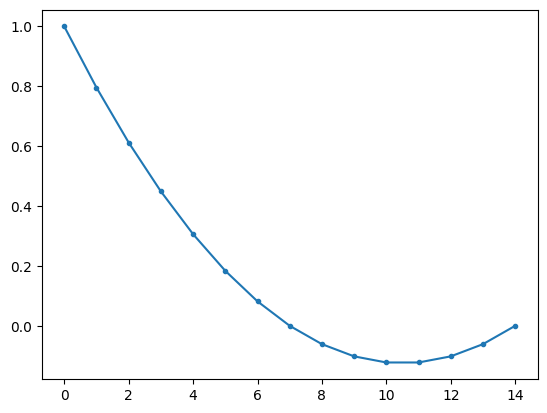

In [472]:
''' From DG_core.ipynb, modified '''

import scipy

# Element order (Gauss points are hard coded)
order = 2
# Set DG number of degrees of freedom
nb = order + 1
nq = nb

# Compute max stretched mesh
# x_min = x_range.min()
# x_max = x_range.max()
x_min = 800
x_max = 1400
ne = 1200
# f.x_mesh = np.linspace(x_min, x_max, ne)

# Fill nodal coordinates, face coordinates, reference element coordinates
x_faces = np.linspace(x_min, x_max, ne + 1)
x_nodes_ref = np.linspace(-1.0, 1.0, nb)
x_nodes = np.empty((ne, nb,))
for i in range(ne):
  x_nodes[i,:] = np.linspace(x_faces[i], x_faces[i+1], nb)
# Fill quadrature coordinates (for order=2)
x_gauss_ref = np.array([-np.sqrt(0.6), 0, np.sqrt(0.6)])
w_gauss_ref = np.array([5/9, 8/9, 5/9])
# Fill (physical) quadrature point locations and weights
x_quad = np.empty((ne, nb,))
w_quad = np.empty((ne, nb,))
geomjac = np.empty((ne,))
for i in range(ne):
  # Apply affine mapping from [-1, 1] -> [x_faces[i], x_faces[i+1]]
  dx = x_faces[i+1] - x_faces[i]
  x_quad[i,:] = (x_faces[i] + x_faces[i+1]) / 2 + (dx / 2) * x_gauss_ref
  # Multiply quadrature weights with geom jacobian
  w_quad[i,:] = (dx / 2) * w_gauss_ref
  geomjac[i] = dx

# Define linear mapping from nodal points to quadrature points (basis_val in quail)
basis_val_map = np.empty((nq, nb))
basis_refgrad_map = np.empty((nq, nb, 1))
for i in range(nb):
  # Create one-hot vector representing nodal values of nodal polynomial
  one_hot = np.zeros((nb,))
  one_hot[i] = 1.0
  # Construct polynomial in scipy convention (monomial basis) on reference nodes
  _loc_poly = scipy.interpolate.lagrange(x_nodes_ref, one_hot)
  # Compute basis map (nodal value |-> value at quad point)
  basis_val_map[:,i] = _loc_poly(x_gauss_ref)
  # Compute basis reference-gradient map (nodal value |-> reference gradient at quad point)
  basis_refgrad_map[:,i,0] = _loc_poly.deriv()(x_gauss_ref)
# Compute physical-space gradient map (ne, nq, nb, 1)
basis_physgrad_map = np.einsum("i, jkl -> ijkl", 2.0 / geomjac, basis_refgrad_map)

# Local reference mass matrix (phi * phi)
M_loc = np.einsum("ki, kj, k -> ij", basis_val_map, basis_val_map, w_gauss_ref)
# Inverse mass matrix assembly (ne, nb, nq)
M_inv = np.einsum("i, jk -> ijk", 2.0 / geomjac, np.linalg.inv(M_loc))

# L2 Projection operator, used to compute 
#   projected = np.einsum("imk, ijl, jk, ij -> iml", M_inv, f_quad, basis_val_map, w_quad)
projection_op = np.einsum("imk, jk, ij -> imj", M_inv, basis_val_map, w_quad)

# Construct transfer operator sending nodal values to linearly spaced interval points
n_interp = 15
x_interp_ref = np.linspace(-1, 1, n_interp)
transfer_map = np.zeros((x_interp_ref.size, nb))
for i in range(nb):
  # Create one-hot vector representing nodal values of nodal polynomial
  one_hot = np.zeros((nb,))
  one_hot[i] = 1.0
  # Construct polynomial in scipy convention (monomial basis) on reference nodes
  _loc_poly = scipy.interpolate.lagrange(x_nodes_ref, one_hot)
  # Compute basis map (nodal value |-> value at quad point)
  transfer_map[:,i] = _loc_poly(x_interp_ref)
# Construct interp mesh (for plotting)
x_interp = np.zeros((ne, x_interp_ref.size))
for i in range(ne):
  # Apply affine mapping from [-1, 1] -> [x_faces[i], x_faces[i+1]]
  dx = x_faces[i+1] - x_faces[i]
  x_interp[i,:] = (x_faces[i] + x_faces[i+1]) / 2 + (dx / 2) * x_interp_ref
# Show one column of transfer map
plt.plot(transfer_map[:,0], '.-')


Text(0.5, 1.0, 'Piecewise parabolic representation of yF from L2 projection')

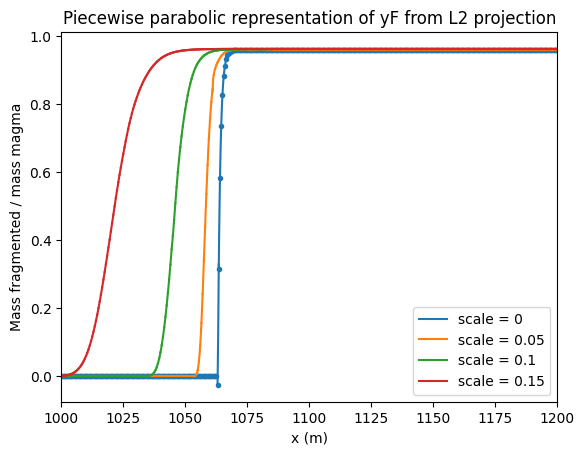

In [473]:
''' Compare L2 projections '''

scale_range = [0, 0.05, 0.1, 0.15]
# Select color palette for lines
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Plot dummy lines for legend top
for scale_idx, _ in enumerate(scale_range):
  plt.plot(x_interp.ravel()[0], 0, '-', color=colors[scale_idx])

for scale_idx, _scale in enumerate(scale_range):
  # Compute pressure-dependent vector solution
  pcoord_sys = f.solve_pcoord_system(100e6, 500, tauf_scale=_scale)

  # Evaluate p at quadrature points
  _p_range = np.linspace(*pcoord_sys["range(p)"], 20000)[::-1]
  p_quad = scipy.interpolate.pchip_interpolate(pcoord_sys["x(p)"](_p_range).ravel(), _p_range, x_quad)
  # Evaluate hyy portion of solution at p(x)
  h_quad = np.zeros_like(x_quad)
  yW_quad = np.zeros_like(x_quad)
  yF_quad = np.zeros_like(x_quad)
  h_quad.ravel()[:], yW_quad.ravel()[:], yF_quad.ravel()[:] = \
    pcoord_sys["hyy(p)"](p_quad.ravel())

  # Compute nodal values through L2 projection from values of yF at quad points
  projected = np.einsum("imj, ij... -> im...", projection_op, yF_quad)
  # Apply node-to-interp-points transfer operator
  vals_interp = np.einsum("km, im... -> ik...", transfer_map, projected)

  # Plot line for each element
  for ie in range(x_interp.shape[0]):
    plt.plot(x_interp[ie,:], vals_interp[ie,:,...], '-', color=colors[scale_idx])
  if scale_idx == 0:
    # Show nodes
    plt.plot(x_interp[:,0], vals_interp[:,0,...], '.', color=colors[scale_idx])
plt.xlim(1000,1200)
plt.xlabel("x (m)")
plt.ylabel("Mass fragmented / mass magma")
plt.legend([f"scale = {val}" for val in scale_range])
plt.title("Piecewise parabolic representation of yF from L2 projection")

Text(0.5, 1.0, 'Piecewise parabolic representation of yF from L2 projection')

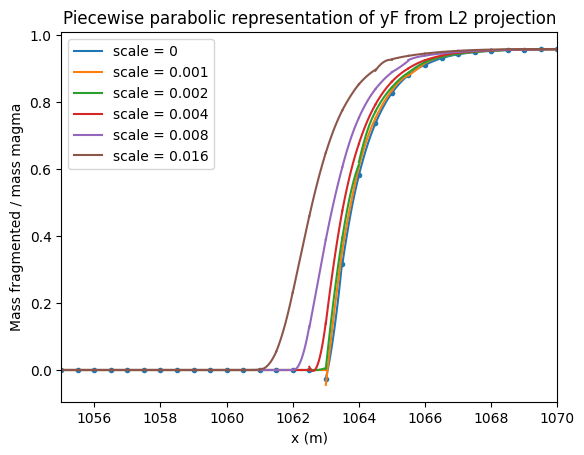

In [476]:
''' Compare L2 projections '''

scale_range = [0, 0.001, 0.002, 0.004, 0.008, 0.016]
# Select color palette for lines
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Plot dummy lines for legend top
for scale_idx, _ in enumerate(scale_range):
  plt.plot(x_interp.ravel()[0], 0, '-', color=colors[scale_idx])

for scale_idx, _scale in enumerate(scale_range):
  # Compute pressure-dependent vector solution
  pcoord_sys = f.solve_pcoord_system(100e6, 500, tauf_scale=_scale)

  # Evaluate p at quadrature points
  _p_range = np.linspace(*pcoord_sys["range(p)"], 20000)[::-1]
  p_quad = scipy.interpolate.pchip_interpolate(pcoord_sys["x(p)"](_p_range).ravel(), _p_range, x_quad)
  # Evaluate hyy portion of solution at p(x)
  h_quad = np.zeros_like(x_quad)
  yW_quad = np.zeros_like(x_quad)
  yF_quad = np.zeros_like(x_quad)
  h_quad.ravel()[:], yW_quad.ravel()[:], yF_quad.ravel()[:] = \
    pcoord_sys["hyy(p)"](p_quad.ravel())

  # Compute nodal values through L2 projection from values of yF at quad points
  projected = np.einsum("imj, ij... -> im...", projection_op, yF_quad)
  # Apply node-to-interp-points transfer operator
  vals_interp = np.einsum("km, im... -> ik...", transfer_map, projected)

  # Plot line for each element
  for ie in range(x_interp.shape[0]):
    plt.plot(x_interp[ie,:], vals_interp[ie,:,...], '-', color=colors[scale_idx])
  if scale_idx == 0:
    # Show nodes
    plt.plot(x_interp[:,0], vals_interp[:,0,...], '.', color=colors[scale_idx])
plt.xlim(1055,1070)
plt.xlabel("x (m)")
plt.ylabel("Mass fragmented / mass magma")
plt.legend([f"scale = {val}" for val in scale_range])
plt.title("Piecewise parabolic representation of yF from L2 projection")

### Smoothing function test

array(0.00013789)

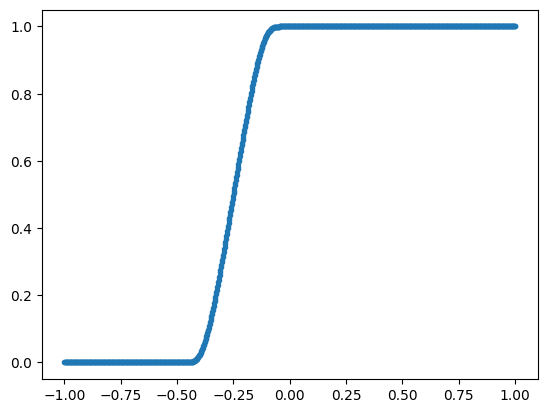

In [188]:
# One-sided smoothing function
_x = np.linspace(-1,1,1000)

def smoother(x, scale):
  ''' Returns one-sided smoothing u(x) of a step, such that
    1. u(x < -scale) = 0
    2. u(x >= 0) = 1.
    3. u smoothly interpolates from 0 to 1 in between.
  '''
  # Shift, scale, and clip to [-1, 0] to prevent exp overflow
  _x = np.clip(x/scale + 1, 0, 1)
  f0 = np.exp(-1/np.where(_x == 0, 1, _x))
  f1 = np.exp(-1/np.where(_x == 1, 1, 1-_x))
  # Return piecewise evaluation
  return np.where(_x >= 1, 1,
           np.where(_x <= 0, 0, 
             f0 / (f0 + f1)))

plt.plot(_x, smoother(_x, 0.5), '.-')
smoother(-0.45, 0.5)

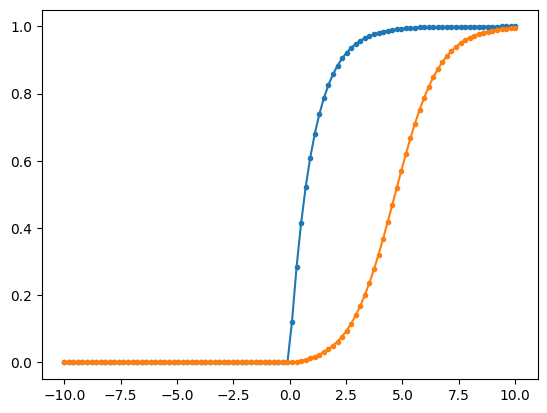

In [217]:
''' Prototypical causal smoothed function '''
import scipy.integrate
_test_sol = scipy.integrate.solve_ivp(lambda t, y: (1 - y) * float(t > 0), (-10,10), [0], dense_output=True).sol
_test_x_range = np.linspace(-10,10,100)
plt.plot(_test_x_range, _test_sol(_test_x_range).ravel(), '.-')

_test_sol = scipy.integrate.solve_ivp(lambda t, y: (y + 0.01) * (1 - y) * float(t > 0), (-10,10), [0], dense_output=True).sol
_test_x_range = np.linspace(-10,10,100)
plt.plot(_test_x_range, _test_sol(_test_x_range).ravel(), '.-')

## Legacy

In [28]:
''' Sweep value of chamber pressure (serial) '''

p_magmastatic = 6e3 * 9.8 * 2.7e3
overpressure_range = 1e6 * np.linspace(1, 150, 50)
# Set mesh for output (not needed for ode solver accuracy control)
x = np.linspace(-6150, -150, 200)

inlet_mass_flux = np.zeros_like(overpressure_range)
inlet_velocity = np.zeros_like(overpressure_range)

for i, overpressure in enumerate(overpressure_range):
  try:
    f = ss.SteadyState(x, 1e5, p_magmastatic + overpressure, input_type="p",
      override_properties=standard_properties)
    sol = f(x, io_format="phy")
    # Extract p, h, mass fraction water exsolved, mass fraction fragmented magma
    p, h, yWv, yF = sol[0:4,:]
    # Mixture temperature
    T = f.T_ph(p, h, yWv)
    # Mixture density
    rho = 1.0 / f.v_mix(p, T, yWv)
    # Get mass flux (flow constant)
    inlet_mass_flux[i] = f.j0
    # Get inlet velocity
    inlet_velocity[i] = (f.j0/rho)[0]
  except:
    inlet_mass_flux[i] = np.nan
    # Get inlet velocity
    inlet_velocity[i] = np.nan


c:\Users\fredr\Documents\compressible-conduit-steady\steady_state.py:266: RuntimeWarning: invalid value encountered in log
  log_mfWd = np.log(mfWd*100)


Choked at vent.
Choked at vent.
Choked at vent.
Choked at vent.
Choked at vent.
Choked at vent.
Choked at vent.
Choked at vent.
Choked at vent.
Choked at vent.
Choked at vent.
Choked at vent.


c:\Users\fredr\Documents\compressible-conduit-steady\material_properties.py:168: RuntimeWarning: invalid value encountered in log
  return self.K/self.rho0 * (u - np.log(1 + u))
c:\Users\fredr\Documents\compressible-conduit-steady\steady_state.py:283: RuntimeWarning: invalid value encountered in double_scalars
  np.sqrt(np.pi) / (2 * alpha) * phi_ratio * (1 + phi_ratio**gamma))
c:\Users\fredr\Documents\compressible-conduit-steady\steady_state.py:284: RuntimeWarning: invalid value encountered in double_scalars
  crysVisc = (1 + phi_ratio**delta) * ((1 - alpha * erf_term)**(-B * phi_cr))


Choked at vent.
Choked at vent.
Choked at vent.
Choked at vent.
Choked at vent.
Choked at vent.
Choked at vent.
Choked at vent.


In [38]:
''' Example for p_inlet input '''
f = ss.SteadyState(x, 1e5, p_magmastatic + 120e6, input_type="p",
      override_properties=standard_properties)
sol = f(x, io_format="phy")
# Extract p, h, mass fraction water exsolved, mass fraction fragmented magma
p, h, yWv, yF = sol[0:4,:]
# Mixture temperature
T = f.T_ph(p, h, yWv)
# Mixture density
rho = 1.0 / f.v_mix(p, T, yWv)
print(f"Inlet velocity: {(f.j0/rho)[0]}")

Choked at vent.


12.764192959092039

In [48]:
''' Load crystal, water component properties. '''
phi_crys = 0.4025 * (1.1 - 0.1 * np.cos(0.0))
chi_water = 0.05055
yWt_init = chi_water * (1 - phi_crys) / (1 + chi_water)
yC_init = phi_crys

In [53]:
props = standard_properties.copy()
props["yWt"] = yWt_init
props["yC"] = phi_crys
props

{'yC': 0.4025,
 'yWt': 0.028750297463233536,
 'yA': 1e-07,
 'yWvInletMin': 1e-07,
 'crit_volfrac': 0.8,
 'tau_d': 1.0,
 'tau_f': 1.0,
 'conduit_radius': 50,
 'T_chamber': 1000,
 'c_v_magma': 3000.0,
 'rho0_magma': 2700.0,
 'K_magma': 10000000000.0,
 'p0_magma': 5000000.0,
 'solubility_k': 5e-06,
 'solubility_n': 0.5}

In [58]:
''' Example for u_inlet input '''
props = standard_properties.copy()
props["yWt"] = yWt_init
props["yC"] = phi_crys
f = ss.SteadyState(x, 1e5, 1, input_type="u",
      override_properties=props)
sol = f(x, io_format="phy")
# Extract p, h, mass fraction water exsolved, mass fraction fragmented magma
p, h, yWv, yF = sol[0:4,:]
# Mixture temperature
T = f.T_ph(p, h, yWv)
# Mixture density
rho = 1.0 / f.v_mix(p, T, yWv)
print(f"Inlet velocity: {(f.j0/rho)[0]}")

Computing lower bound on pressure given domain length.
Minimum vent pressure is 271223.85562354635.
Choked flow.
232559651.003268 2761.4392041584993
232559651.003268 2761.4392041584993
Inlet velocity: 1.0


In [57]:
phi_crys

0.4025

Text(0, 0.5, 'Depth (m)')

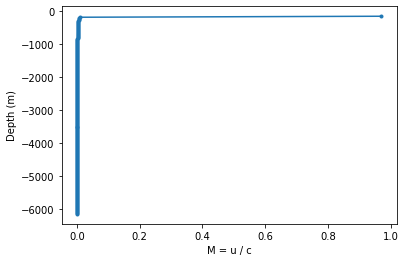

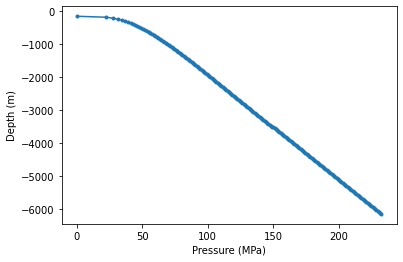

In [71]:
''' Example plotting Mach number ''' 
u = f.j0/rho
c_fn = lambda p, h, yWv: f.mixture.sound_speed(
  p, f.T_ph(p, h, yWv), f.yA, yWv, 1.0 - f.yA - yWv)
c = np.array(list(map(c_fn, p, h, yWv)))
M = u / c
plt.figure()
plt.plot(M, x, '.-')
plt.xlabel("M = u / c")
plt.ylabel("Depth (m)")

plt.figure()
plt.plot(p/1e6, x, '.-')
plt.xlabel("Pressure (MPa)")
plt.ylabel("Depth (m)")

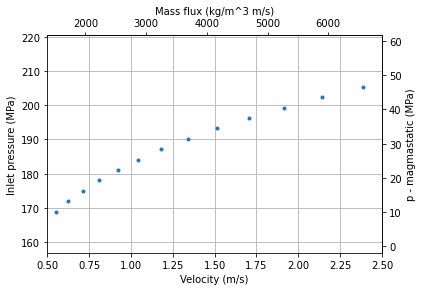

In [29]:
''' Generate pressure-velocity relation given vent pressure, parameters. '''

ax = plt.axes()
ax.plot(inlet_velocity, (p_magmastatic + overpressure_range)/1e6, '.')
plt.xlim(0.5, 2.5)
plt.xlabel("Velocity (m/s)")
plt.ylabel("Inlet pressure (MPa)")
u2j = lambda u: np.interp(u, inlet_velocity, inlet_mass_flux)
j2u = lambda j: np.interp(j, inlet_mass_flux, inlet_velocity)
secxax = ax.secondary_xaxis('top', functions=(u2j, j2u))
secxax.set_xlabel("Mass flux (kg/m^3 m/s)")
secyax = ax.secondary_yaxis('right', 
  functions=(lambda p: (p - p_magmastatic/1e6), lambda p: p_magmastatic/1e6 + p))
secyax.set_ylabel("p - magmastatic (MPa)")
plt.grid("both")

## Recycle Bin

(-6200.0, -6000.0)

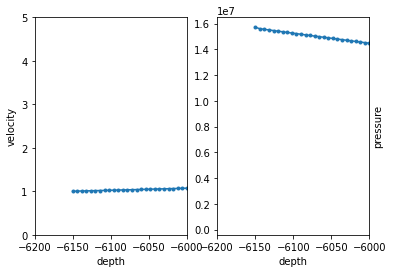

In [304]:
j0 = 1.0 / v_map(p[0], h[0], y[0], yF[0])
u = j0 * v_map(p, h, y, yF)

plt.subplot(1,2,1)
plt.plot(x, u, '.-')
plt.xlabel("depth")
plt.xlim(-6200, -6000)
plt.ylim(0, 5)
plt.ylabel("velocity")

plt.subplot(1,2,2)
ax = plt.plot(x, p, '.-')
plt.ylabel("pressure")
plt.gca().yaxis.set_label_position("right")
plt.xlabel("depth")
plt.xlim(-6200, -6000)

In [275]:
f.yWvInletMin, f.y_wv_eq(3.4e6), f.yWt - f.x_sat(p[0]) * (1.0 - f.yC - f.yWt - f.yA), p[0]

(1e-05, 0.033915100658186696, 0.03392338822127275, 3390745.8125644773)

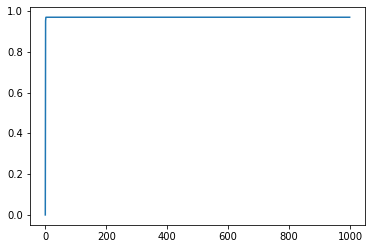

In [22]:
plt.plot(yF)

In [23]:
f.p_chamber

1973728.038736085

# Testing against Quail flux

In [5]:
''' Reconstruct primitive state using atomics in Quail's ndarray format '''
import atomics
U = np.expand_dims(U1, axis=0)
rho = U[...,0:3].sum(axis=-1)
u = U[...,3] / rho
class Physics():
  def __init__(self):
    self.Liquid = {
      "E_m0": 0,
      "c_m": f.mixture.magma.c_v,
      "K": f.mixture.magma.K,
      "p0": f.mixture.magma.p_ref,
      "rho0": f.mixture.magma.rho0,
    }
    self.Gas = [
      {"c_v": f.mixture.air.c_v, "c_p": f.mixture.air.c_p, "R": f.mixture.air.R},
      {"c_v": f.mixture.waterEx.c_v, "c_p": f.mixture.waterEx.c_p, "R": f.mixture.waterEx.R},
    ]
physics = Physics()
T_recons = atomics.temperature(U[...,0:3], U[...,3:4], U[...,4:5], physics)
gas_volfrac = atomics.gas_volfrac(U[...,0:3], T_recons, physics)
p_recons = atomics.pressure(U[...,0:3], T_recons, gas_volfrac, physics)

ModuleNotFoundError: No module named 'atomics'

In [6]:
# Test reconstructed pressure
plt.plot(x.ravel(), p_recons.ravel())
plt.plot(x.ravel(), p.ravel(), '--')

NameError: name 'p_recons' is not defined

In [ ]:
(U[...,6]/rho).shape

(1, 1000)

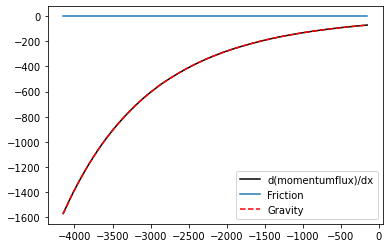

In [ ]:
# Finite difference testing for the steady-state

f_momentum = rho * u * u + p
dfdx = np.diff(f_momentum.ravel()) / (x.ravel()[1] - x.ravel()[0])
x_mean = np.mean([x[1:], x[:-1]], axis=0)
plt.plot(x_mean, dfdx, 'k')

fric = np.zeros_like(p)
grav = rho * -9.8
for i in range(len(p)):
  # print(p[i], T_recons.ravel()[i], (U[...,1]/rho)[i], (U[...,6]/rho)[i], (U[...,5]/rho)[i], u[i])
  fric[i] = f.F_fric(p.ravel()[i], T_recons.ravel()[i], (U[...,1]/rho).ravel()[i], (U[...,6]/rho).ravel()[i], (U[...,5]/rho).ravel()[i], u.ravel()[i])
# 
# p, T_recons, y, 
# for i, args in enumerate(zip(p, T_recons, y, f.yC*np.ones_like(u), f.yWt*np.ones_like(u), u)):
#   print(*args)
#   fric[i] = f.F_fric(p, T_recons, U[...,1:2]/rho, U[...,6:7]/rho, U[...,5:6]/rho, u)
# s_momentum = f.F_fric(p, T_recons, y, f.yC, f.yWt, u)
plt.plot(x, fric.ravel())
plt.plot(x, grav.ravel(), 'r--')
# plt.plot(x, dfdx)
# plt.plot(x, dfdx/grav.ravel()[1:])

plt.legend(["d(momentumflux)/dx", "Friction", "Gravity"])

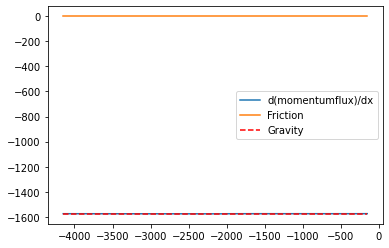

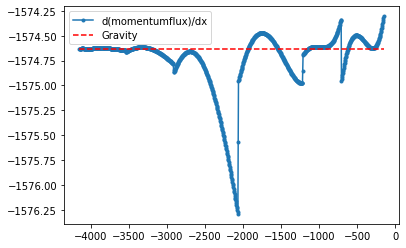

In [ ]:
f_energy = f.j0 * h + 0.5 * f.j0 * u * u
dfedx = np.diff(f_energy.ravel()) / (x.ravel()[1] - x.ravel()[0])

plt.plot(x_mean, dfedx)
plt.plot(x, u.ravel()*fric.ravel())
plt.plot(x, u.ravel()*grav.ravel(), 'r--')
plt.legend(["d(momentumflux)/dx", "Friction", "Gravity"])
plt.figure()
plt.plot(x_mean, dfedx, '.-')
plt.plot(x, u.ravel()*grav.ravel(), 'r--')
plt.legend(["d(momentumflux)/dx", "Gravity"])

In [75]:
x, (p,h,y,yF) = f.solve_steady_state_problem(1e5, 1, input_type="u")[0:2]

Pressure matching for vent pressure at given velocity.


In [60]:
f.x_mesh = np.linspace(-6000, 0, 100)


In [61]:
f.p_chamber, f.j0

(1973753.512248449, 161.85242632748594)

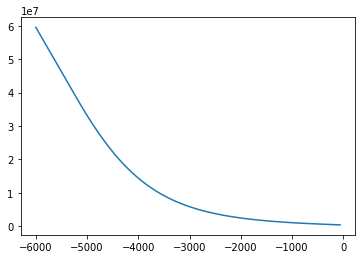

In [62]:
plt.plot(x,p)

# One

In [16]:
p_vent = 1e5
# f.solve_steady_state_problem(p_vent, 1.0, "u")
p_sweep = np.linspace(0.2e6, 100e6, 10)
j0_sweep = np.linspace(1, 10*2700, 36)

mg_p, mg_j0 = np.meshgrid(p_sweep, j0_sweep)
mg_out = np.zeros_like(mg_p)

# for j, p in enumerate(mg_p):
#   for i in enumerate()
# f.solve_ssIVP(p, j0)

# E

In [66]:
'''Set limits for chamber pressure, mass flux sweep'''

# p_sweep = np.linspace(0.1e5, 100e6, 84) # Fine
p_sweep = np.linspace(0.1e5, 100e6, 24) # Coarse
# j0_sweep = np.linspace(50, 25000, 60) # Fine
j0_sweep = np.linspace(50, 25000, 20) # Coarse

mg_p, mg_j0 = np.meshgrid(p_sweep, j0_sweep)
# Set output size
p_out = np.ones((*mg_p.shape, 1000))
outs = [[None]*len(p_sweep) for _ in range(len(j0_sweep))]

In [67]:
f.yL

0.7699999

In [68]:
''' Compute loop '''
p_top = np.zeros_like(mg_p)
# for i, (p, j0) in enumerate(zip(mg_p.ravel(), mg_j0.ravel())):
for j, p in enumerate(p_sweep):     # Iterate horizontal axis
  for i, j0 in enumerate(j0_sweep): # Iterate vertical axis
    outs[i][j] = f.solve_ssIVP(p, j0)
    p_top[i, j] = outs[i][j][1][0][-1]
  print(j)


0
1
2


c:\Users\Fredric\Documents\Volcano\compressible-conduit-steady\steady_state.py:207: RuntimeWarning: invalid value encountered in log
  log_mfWd = np.log(mfWd*100)


3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


In [56]:
# Define and test velocity map (p_chamber, j0) -> u_chamber
uc_map = lambda p_chamber, j0: j0 * f.v_mix(p_chamber, f.T_chamber, np.max((f.yWvInletMin, f.y_wv_eq(p))))
uc_map(10e6, 1e3)
# Define and test v map (p, h, y) -> v
v_map = lambda p, h, y, yF: f.v_mix(p,
  f.mixture.T_ph(p, h, f.yA, y, 1.0 - f.yA - y), y)
v_map(*outs[i][j][1][:,-1])
# Define and test sound speed map (p, h, y) -> c
c_map = lambda p, h, y, yF: f.mixture.sound_speed(p,
  f.mixture.T_ph(p, h, f.yA, y, 1.0 - f.yA - y), f.yA, y, 1.0 - f.yA - y)
c_map(*outs[i][j][1][:,-1])

121.40008752441473

In [205]:
target_mesh, f.x_mesh = f.x_mesh, np.array([f.x_mesh[0], f.x_mesh[-1]])
target_mesh_safe = target_mesh

In [144]:
# Fix j0
j0 = 2700

# Rising pressure
pmin = 3.75e5
for k in range(11):
  p0 = pmin
  _out = f.solve_ssIVP(p0*2**k, j0)
  p_top = _out[1][0,-1]
  # plt.plot(_out[1][0,:])
  # _out[2]

  # Top pressure and pressure grad check
  q_top = _out[1][:,-1]
  dqdx = np.linalg.solve(f.A(*q_top, j0), f.F(q_top)).flatten()
  dpdx = dqdx[0]
  # Tolerable distance-to-zero-pressure
  p_min = 0.001e6 # 1 mbar
  dx_min = 1.0    # 1 m until zero pressure
  vacuum_condition = p_top < p_min or p_top/np.abs(dpdx) < dx_min
  print(p_top, dpdx, vacuum_condition)
  # f.eigA(*_out[1][:,-1], j0)[1], c_map(*_out[1][:,-1]), j0 * v_map(*_out[1][:,-1])


375000.0 -2054540810.873913 True
750000.0 -125254673.51856352 True
1500000.0 -17775446.91372559 True
3000000.0 -2699916.6057843296 False
319641.99415922875 -3666.7631884081384 False
322976.1147778986 -2850.0212770483595 False
476719.4612589631 -619.3118546387718 False
1184006.7084672628 -964.8617451419312 False
4808653.470008825 -3844.388019466481 False
80874425.8342737 -27638.51904116448 False
270919522.8407911 -28125.899560337548 False


In [ ]:
''' Bounder '''

def compute_lowest_chamber_pressure(u):
  # Swap grid meshing for faster processing
  target_mesh, f.x_mesh = f.x_mesh, np.linspace(f.x_mesh[0], f.x_mesh[-1], 10)

  # Number of times to double pressure while searching for choking pressure
  N_doubling = 25

  ''' Compute loose lower bound on pressure due to gravity. '''
  # Lower bound pressure
  yMax = f.yWt - f.x_sat(p_vent) * (1.0 - f.yC - f.yWt - f.yA)
  # Compute maximum water vapour volume
  vwMax = 1.0 / p_vent * f.mixture.waterEx.R * f.T_chamber
  # Compute maximum mixture volume
  vMax = yMax * vwMax + (1 - yMax) * f.mixture.magma.v_pT(p_vent, None)
  p_minbound = p_vent + f.conduit_length * 9.8 /  vMax

  ''' Find lowest-pressure continuous solution '''
  p0 = p_minbound
  for k in range(N_doubling):
    # Compute IVP solution
    
    p_chamber = p0*2**k
    j0 = u / f.v_mix(p_chamber, f.T_chamber,
      np.clip(f.y_wv_eq(p_chamber), f.yWvInletMin, None))
    _out = f.solve_ssIVP(p0*2**k, j0)
    p_top = _out[1][0,-1]
    x_top = _out[0][-1]
    ''' Top pressure and pressure grad check'''
    q_top = _out[1][:,-1]
    dqdx = np.linalg.solve(f.A(*q_top, j0), f.F(q_top)).flatten()
    dpdx = dqdx[0]
    # Tolerable distance-to-zero-pressure
    p_min = 0.001e6 # 1 mbar
    dx_min = 1.0    # 1 m until zero pressure
    is_reached_vacuum = p_top < p_min or p_top/np.abs(dpdx) < dx_min
    # Search criterion
    if x_top >= f.x_mesh[-1]:
      break
  else:
    raise Exception("Could not bracket lower pressure limit.")

  def bisect_pmin(a,b):
    ''' Manual bisection for minimum pressure. '''
    fn_x_top = lambda p: f.solve_ssIVP(p, j0)[0][-1]
    # Reject if continuous solution at low bracketing pressure
    if fn_x_top(a) >= f.x_mesh[-1]:
      raise ValueError(f"Pressure {a} is a continuous solution.")
    # Reject if no continuous solution at high bracketing pressure
    if fn_x_top(b) < f.x_mesh[-1]:
      raise ValueError(f"Pressure {b} is not a continuous solution.")

    abs_tol = 1e-1
    m = 0.5*(a+b)

    while b - a > abs_tol:
      # Search criterion
      if fn_x_top(m) >= f.x_mesh[-1]: # Continuous solution found
        b = m
      else:
        a = m
      m = 0.5*(a+b)
    return b # Continuous solution

  # Compute minimum possible chamber pressure
  pc_min = bisect_pmin(p0*2**k/2, p0*2**k)

  return pc_min

  ''' Define quick state maps '''
  # Define and test velocity map (p_chamber, j0) -> u_chamber
  uc_map = lambda p_chamber, j0: \
    j0 * f.v_mix(p_chamber, f.T_chamber, np.max((f.yWvInletMin, f.y_wv_eq(p))))
  # Define and test v map (p, h, y) -> v
  v_map = lambda p, h, y, yF: f.v_mix(p,
    f.mixture.T_ph(p, h, f.yA, y, 1.0 - f.yA - y), y)
  v_map(*outs[i][j][1][:,-1])
  # Define and test sound speed map (p, h, y) -> c
  c_map = lambda p, h, y, yF: f.mixture.sound_speed(p,
    f.mixture.T_ph(p, h, f.yA, y, 1.0 - f.yA - y), f.yA, y, 1.0 - f.yA - y)
  c_map(*outs[i][j][1][:,-1])
  def fn_M_top(p):
    q = f.solve_ssIVP(p, j0)[1][:,-1]
    return j0 * v_map(*q) / c_map(*q)
  def fn_p_top(p):
    return f.solve_ssIVP(p, j0)[1][0,-1]

  ''' Plot top state for p >= p_min '''

  p_scan_range = np.linspace(pc_min, 10*pc_min, 50)
  plt.figure()
  plt.plot(p_scan_range, [fn_M_top(p) for p in p_scan_range], '.')
  plt.figure()
  plt.plot(p_scan_range, [fn_p_top(p) for p in p_scan_range], '.')
  print("Assume monotonic relationship p_chamber <-> p_vent. " + 
    "Then if p_vent < p_vent(p_low) then there is choking.")

# j0_test_range = np.array([10, 100, 1000, 2000, 3000, 4000, 5000, 10000])
# pmin_vals = [compute_lowest_chamber_pressure(j0) for j0 in j0_test_range]
# characterize(2000)

u_test_range = np.array([0.1, 1, 2, 3, 10, 20, 30])
pmin_vals = [compute_lowest_chamber_pressure(u) for u in u_test_range]


c:\Users\Fredric\Documents\Volcano\compressible-conduit-steady\steady_state.py:207: RuntimeWarning: invalid value encountered in log
  log_mfWd = np.log(mfWd*100)


Text(0.5, 0, 'Velocity at choke')

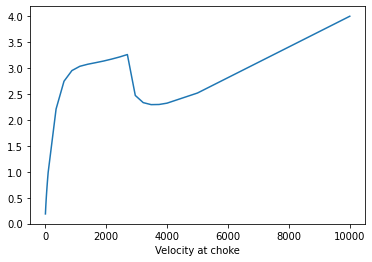

In [263]:
''' Bounder (j0 variant) '''

def compute_lowest_chamber_pressure_j0(j0):
  # Swap grid meshing for faster processing
  target_mesh, f.x_mesh = f.x_mesh, np.linspace(f.x_mesh[0], f.x_mesh[-1], 10)

  # Number of times to double pressure while searching for choking pressure
  N_doubling = 25

  ''' Compute loose lower bound on pressure due to gravity. '''
  # Lower bound pressure
  yMax = f.yWt - f.x_sat(p_vent) * (1.0 - f.yC - f.yWt - f.yA)
  # Compute maximum water vapour volume
  vwMax = 1.0 / p_vent * f.mixture.waterEx.R * f.T_chamber
  # Compute maximum mixture volume
  vMax = yMax * vwMax + (1 - yMax) * f.mixture.magma.v_pT(p_vent, None)
  p_minbound = p_vent + f.conduit_length * 9.8 /  vMax

  ''' Find lowest-pressure continuous solution '''
  p0 = p_minbound
  for k in range(N_doubling):
    # Compute IVP solution
    
    p_chamber = p0*2**k
    _out = f.solve_ssIVP(p0*2**k, j0)
    p_top = _out[1][0,-1]
    x_top = _out[0][-1]
    ''' Top pressure and pressure grad check'''
    q_top = _out[1][:,-1]
    dqdx = np.linalg.solve(f.A(*q_top, j0), f.F(q_top)).flatten()
    dpdx = dqdx[0]
    # Tolerable distance-to-zero-pressure
    p_min = 0.001e6 # 1 mbar
    dx_min = 1.0    # 1 m until zero pressure
    is_reached_vacuum = p_top < p_min or p_top/np.abs(dpdx) < dx_min
    # Search criterion
    if x_top >= f.x_mesh[-1]:
      break
  else:
    raise Exception("Could not bracket lower pressure limit.")

  def bisect_pmin(a,b):
    ''' Manual bisection for minimum pressure. '''
    fn_x_top = lambda p: f.solve_ssIVP(p, j0)[0][-1]
    # Reject if continuous solution at low bracketing pressure
    if fn_x_top(a) >= f.x_mesh[-1]:
      raise ValueError(f"Pressure {a} is a continuous solution.")
    # Reject if no continuous solution at high bracketing pressure
    if fn_x_top(b) < f.x_mesh[-1]:
      raise ValueError(f"Pressure {b} is not a continuous solution.")

    abs_tol = 1e-1
    m = 0.5*(a+b)

    while b - a > abs_tol:
      # Search criterion
      if fn_x_top(m) >= f.x_mesh[-1]: # Continuous solution found
        b = m
      else:
        a = m
      m = 0.5*(a+b)
    return b # Continuous solution

  # Compute minimum possible chamber pressure
  pc_min = bisect_pmin(p0*2**k/2, p0*2**k)

  return pc_min

  ''' Define quick state maps '''
  # Define and test velocity map (p_chamber, j0) -> u_chamber
  uc_map = lambda p_chamber, j0: \
    j0 * f.v_mix(p_chamber, f.T_chamber, np.max((f.yWvInletMin, f.y_wv_eq(p))))
  # Define and test v map (p, h, y) -> v
  v_map = lambda p, h, y, yF: f.v_mix(p,
    f.mixture.T_ph(p, h, f.yA, y, 1.0 - f.yA - y), y)
  v_map(*outs[i][j][1][:,-1])
  # Define and test sound speed map (p, h, y) -> c
  c_map = lambda p, h, y, yF: f.mixture.sound_speed(p,
    f.mixture.T_ph(p, h, f.yA, y, 1.0 - f.yA - y), f.yA, y, 1.0 - f.yA - y)
  c_map(*outs[i][j][1][:,-1])
  def fn_M_top(p):
    q = f.solve_ssIVP(p, j0)[1][:,-1]
    return j0 * v_map(*q) / c_map(*q)
  def fn_p_top(p):
    return f.solve_ssIVP(p, j0)[1][0,-1]

  ''' Plot top state for p >= p_min '''

  p_scan_range = np.linspace(pc_min, 10*pc_min, 50)
  plt.figure()
  plt.plot(p_scan_range, [fn_M_top(p) for p in p_scan_range], '.')
  plt.figure()
  plt.plot(p_scan_range, [fn_p_top(p) for p in p_scan_range], '.')
  print("Assume monotonic relationship p_chamber <-> p_vent. " + 
    "Then if p_vent < p_vent(p_low) then there is choking.")

# j0_test_range = np.array([10.0, 100, 1000, 2000, 3000, 4000, 5000, 10000])
j0_test_range = np.array([*np.linspace(10,100,8)[:-1], *np.linspace(100,4000,16), 5000, 10000])
pmin_vals = [compute_lowest_chamber_pressure_j0(j0) for j0 in j0_test_range]
u = np.zeros_like(j0_test_range)
for i, j0 in enumerate(j0_test_range):
  p = pmin_vals[i]
  u[i] = j0 * f.v_mix(p, f.T_chamber, np.clip(f.y_wv_eq(p), f.yWvInletMin, None))
plt.plot(j0_test_range, u)
plt.xlabel("Mass flux")
plt.ylabel("Velocity at choke")

Text(0, 0.5, 'Velocity at choke')

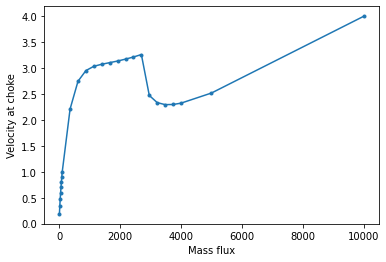

In [265]:
plt.plot(j0_test_range, u, '.-')
plt.xlabel("Mass flux")
plt.ylabel("Velocity at choke")

In [262]:
j0_test_range = np.array([*np.linspace(10,100,5)[:-1], *np.linspace(100,4000,8), 5000, 10000])

array([   10.        ,    32.5       ,    55.        ,    77.5       ,
         100.        ,   657.14285714,  1214.28571429,  1771.42857143,
        2328.57142857,  2885.71428571,  3442.85714286,  4000.        ,
        5000.        , 10000.        ])

0.18638147289084886
0.9868807608992283
3.002110746665251
3.1476273116016196
2.4396310850681733
2.3239237173653837
2.519663698794184
4.001649006382766


array([0.18638147, 0.98688076, 3.00211075, 3.14762731, 2.43963109,
       2.32392372, 2.5196637 , 4.00164901])

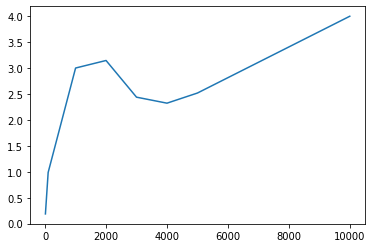

In [260]:
# Inlet velocity u as a function of j0, at minimum p
j0_test_range = np.array([10.0, 100, 1000, 2000, 3000, 4000, 5000, 10000])
u = np.zeros_like(j0_test_range)
for i, j0 in enumerate(j0_test_range):
  p = pmin_vals[i]
  print(j0 * f.v_mix(p, f.T_chamber, np.clip(f.y_wv_eq(p), f.yWvInletMin, None)))
  u[i] = j0 * f.v_mix(p, f.T_chamber, np.clip(f.y_wv_eq(p), f.yWvInletMin, None))
plt.plot(j0_test_range, u)
u

ValueError: x and y must have same first dimension, but have shapes (7,) and (8,)

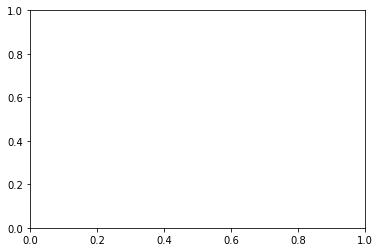

In [249]:
plt.plot(u_test_range, pmin_vals, '.-')

In [226]:
# For target u = 1 m/s
u = 1
p_vent = 1e5

p_min = compute_lowest_chamber_pressure(u)
p_vent_min = f.solve_ssIVP(p_min, j0)[1][0,-1]
if p_vent <= p_vent_min:
  # Choked
  pass
else:
  # Unchoked: solve using bounds
  (p_min, p_max)
  pass

107992.61770660698

Text(0, 0.5, 'Min chamber pressure (Pa)')

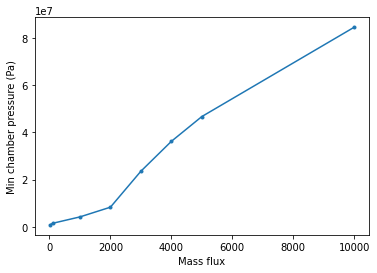

In [221]:
plt.plot(j0_test_range, pmin_vals, '.-')
plt.xlabel("Mass flux")
plt.ylabel("Min chamber pressure (Pa)")

In [200]:
j0 = 1

# Find lowest continuous solution
pmin = 3.75e5
for k in range(25):
  p0 = pmin
  _out = f.solve_ssIVP(p0*2**k, j0)
  p_top = _out[1][0,-1]
  x_top = _out[0][-1]
  ''' Top pressure and pressure grad check'''
  q_top = _out[1][:,-1]
  dqdx = np.linalg.solve(f.A(*q_top, j0), f.F(q_top)).flatten()
  dpdx = dqdx[0]
  # Tolerable distance-to-zero-pressure
  p_min = 0.001e6 # 1 mbar
  dx_min = 1.0    # 1 m until zero pressure
  is_reached_vacuum = p_top < p_min or p_top/np.abs(dpdx) < dx_min
  # Search criterion
  if x_top >= f.x_mesh[-1]:
    break
else:
  raise Exception("Could not bracket lower pressure limit.")

fn_x_top = lambda p: f.solve_ssIVP(p, j0)
_xp_ = [(fn_x_top(p)[0][-1], fn_x_top(p)[1][0,-1]) for p in np.linspace(p0*2**k, p0*2**k/2, 10)]

c:\Users\Fredric\Documents\Volcano\compressible-conduit-steady\steady_state.py:207: RuntimeWarning: invalid value encountered in log
  log_mfWd = np.log(mfWd*100)


In [201]:
# Manual bisection
def bisect_pmin(a,b):
  ''' Manual bisection for minimum pressure. '''
  fn_x_top = lambda p: f.solve_ssIVP(p, j0)[0][-1]
  # Reject if continuous solution at low bracketing pressure
  if fn_x_top(a) >= f.x_mesh[-1]:
    raise ValueError(f"Pressure {a} is a continuous solution.")
  # Reject if no continuous solution at high bracketing pressure
  if fn_x_top(b) < f.x_mesh[-1]:
    raise ValueError(f"Pressure {b} is not a continuous solution.")

  abs_tol = 1e-7
  m = 0.5*(a+b)

  while b - a > abs_tol:
    # Search criterion
    if fn_x_top(m) >= f.x_mesh[-1]: # Continuous solution found
      b = m
    else:
      a = m
    m = 0.5*(a+b)
  return b # Continuous solution

# Lower pressure
p_low = bisect_pmin(p0*2**k/2, p0*2**k)

In [202]:
p0*2**k, p0*2**k/2, p_low

(750000.0, 375000.0, 449332.27776812145)

(0.015516060728272387, 116.95887222003898)

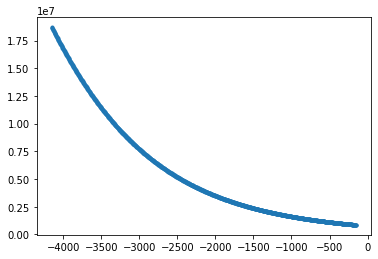

In [203]:
_out_min = f.solve_ssIVP(18.7e6, j0)
plt.plot(_out_min[0], _out_min[1][0,:], '.-')
j0 * v_map(*_out_min[1][:,-1]), c_map(*_out_min[1][:,-1])

In [194]:
fn_p_top(p_low)

314687.23472164065

c:\Users\Fredric\Documents\Volcano\compressible-conduit-steady\steady_state.py:207: RuntimeWarning: invalid value encountered in log
  log_mfWd = np.log(mfWd*100)
c:\Users\Fredric\Documents\Volcano\compressible-conduit-steady\steady_state.py:207: RuntimeWarning: invalid value encountered in log
  log_mfWd = np.log(mfWd*100)


Assume monotonic relationship p_chamber <-> p_vent. Then if p_vent < p_vent(p_low) then there is choking.


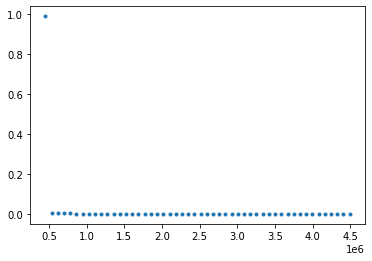

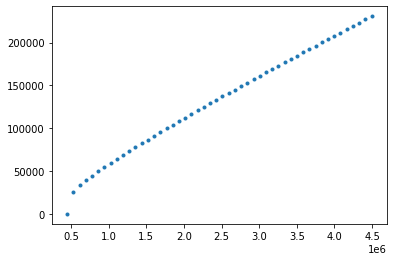

In [204]:
def fn_M_top(p):
  q = f.solve_ssIVP(p, j0)[1][:,-1]
  return j0 * v_map(*q) / c_map(*q)
def fn_p_top(p):
  return f.solve_ssIVP(p, j0)[1][0,-1]

p_scan_range = np.linspace(p_low, 10*p_low, 50)
plt.figure()
plt.plot(p_scan_range, [fn_M_top(p) for p in p_scan_range], '.')
plt.figure()
plt.plot(p_scan_range, [fn_p_top(p) for p in p_scan_range], '.')
print("Assume monotonic relationship p_chamber <-> p_vent. " + 
  "Then if p_vent < p_vent(p_low) then there is choking.")

In [163]:
_x_, _p_ = zip(*_xp_)
scipy.optimize.solve(- x_top f.x_mesh[-1])

(-150.0,
 -150.0,
 -150.0,
 -150.0,
 -154.0040040040035,
 -198.0480480480478,
 -234.08408408408377,
 -266.1161161161158,
 -294.14414414414387,
 -310.16016016015965)

In [135]:
# Lower bound pressure
yMax = f.yWt - f.x_sat(p_vent) * (1.0 - f.yC - f.yWt - f.yA)
# Compute maximum water vapour volume
vwMax = 1.0 / p_vent * f.mixture.waterEx.R * f.T_chamber
# Compute maximum mixture volume
vMax = yMax * vwMax + (1 - yMax) * f.mixture.magma.v_pT(p_vent, None)
p_vent + f.conduit_length * 9.8 /  vMax


374375.6901743374

In [ ]:

# Falling algorithm
pmax = 0.1
p0 = pmax
_out = f.solve_ssIVP(p0, j0)
_out[0][-1]
# f.eigA(*_out[1][:,-1], j0)[0]

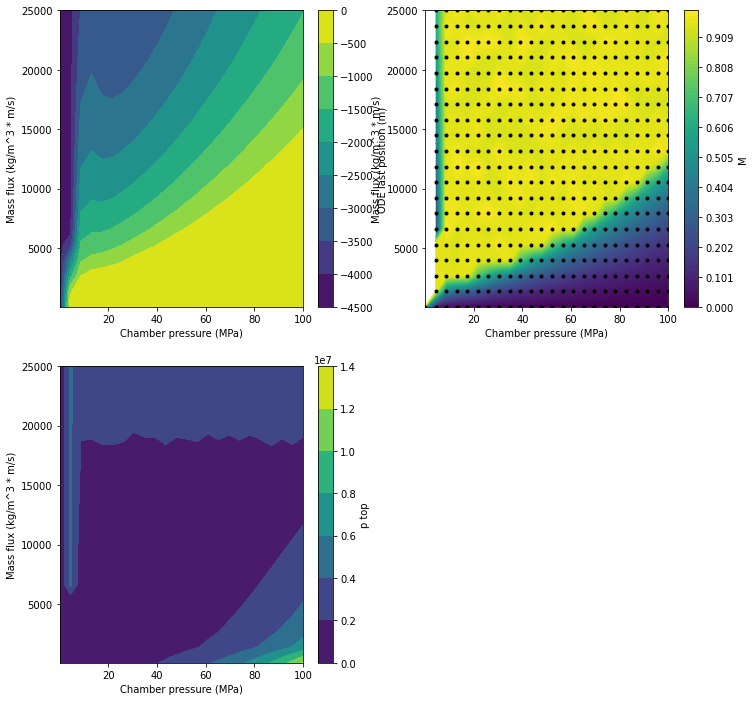

In [76]:
x_final = np.zeros_like(mg_p)
M_final = np.zeros_like(mg_p)
c_final = np.zeros_like(mg_p)
u_final = np.zeros_like(mg_p)
p_final = np.zeros_like(mg_p)

for j, p in enumerate(p_sweep):     # Iterate horizontal axis
  for i, j0 in enumerate(j0_sweep): # Iterate vertical axis
    x_final[i,j] = outs[i][j][0][-1]
    c_final[i,j] = c_map(*outs[i][j][1][:,-1])
    u_final[i,j] = j0 * v_map(*outs[i][j][1][:,-1])
    M_final[i,j] = u_final[i,j] / c_final[i,j]
    p_final[i,j] = outs[i][j][1][0,-1]

plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
plt.contourf(mg_p/1e6, mg_j0, x_final)
plt.xlabel("Chamber pressure (MPa)")
plt.ylabel("Mass flux (kg/m^3 * m/s)")
cb = plt.colorbar()
cb.set_label("ODE last position (m)")

plt.subplot(2,2,2)
plt.contourf(mg_p/1e6, mg_j0, M_final, levels=np.linspace(0,1,100))
plt.xlabel("Chamber pressure (MPa)")
plt.ylabel("Mass flux (kg/m^3 * m/s)")
plt.clim(0, 1)
plt.plot(mg_p[np.where(np.abs(M_final) <= 1.0)]/1e6, mg_j0[np.where(np.abs(M_final) <= 1.0)], 'k.')
cb = plt.colorbar()
cb.set_label("M")

plt.subplot(2,2,3)
plt.contourf(mg_p/1e6, mg_j0, p_final)
plt.xlabel("Chamber pressure (MPa)")
plt.ylabel("Mass flux (kg/m^3 * m/s)")
cb = plt.colorbar()
cb.set_label("p top")

plt.subplot(2,2,4)
plt.contourf(mg_p/1e6, mg_j0, p_final)
plt.xlabel("Chamber pressure (MPa)")
plt.ylabel("Mass flux (kg/m^3 * m/s)")
cb = plt.colorbar()
cb.set_label("p top")

plt.figure(figsize=(12,6))
plt.contourf(mg_p/1e6, mg_j0, M_final, levels=np.linspace(0,1,100))


In [65]:
M_final

array([[6.04068039e-01, 1.33574121e-02, 7.13791895e-03, 4.60069118e-03,
        3.20260188e-03, 2.31558829e-03, 1.70814117e-03, 1.27590488e-03,
        9.49803707e-04, 7.02801927e-04, 5.16353305e-04, 3.67281467e-04],
       [3.40962849e+01, 9.49863602e-01, 9.61483746e-01, 6.01315586e-01,
        4.09018164e-01, 2.95543961e-01, 2.19645678e-01, 1.65849169e-01,
        1.25993043e-01, 9.54746308e-02, 7.20669630e-02, 5.41017759e-02],
       [6.75885017e+01, 9.43865486e-01, 9.82451223e-01, 9.85565709e-01,
        9.50891779e-01, 9.51088009e-01, 7.52591756e-01, 4.91955962e-01,
        3.58709686e-01, 2.68143821e-01, 2.02246554e-01, 1.52863870e-01],
       [1.01080719e+02, 9.59626533e-01, 9.54375234e-01, 9.83664762e-01,
        9.76044726e-01, 9.50323208e-01, 9.65982302e-01, 9.63979623e-01,
        9.47023975e-01, 5.72809094e-01, 4.07725646e-01, 3.02295793e-01],
       [1.34572935e+02, 9.52873599e-01, 9.56833990e-01, 9.42775434e-01,
        9.62631216e-01, 9.46104872e-01, 9.49359741e-01, 9.83

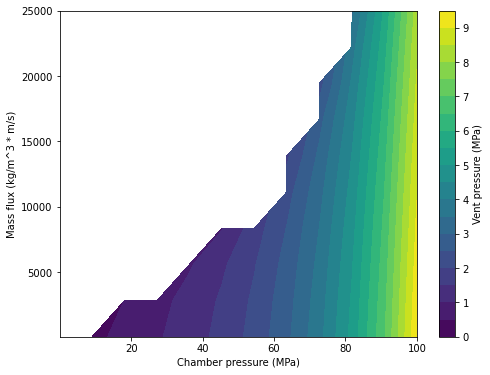

In [81]:
p_final = np.zeros_like(mg_p)

for j, p in enumerate(p_sweep):     # Iterate horizontal axis
  for i, j0 in enumerate(j0_sweep): # Iterate vertical axis
    p_final[i,j] = outs[i][j][1][0,-1]
p_final = np.where(x_final < f.x_mesh[-1], np.nan, p_final)

plt.figure(figsize=(8,6))
plt.contourf(mg_p/1e6, mg_j0, p_final/1e6, levels=20)
plt.xlabel("Chamber pressure (MPa)")
plt.ylabel("Mass flux (kg/m^3 * m/s)")
cb = plt.colorbar()
cb.set_label("Vent pressure (MPa)")

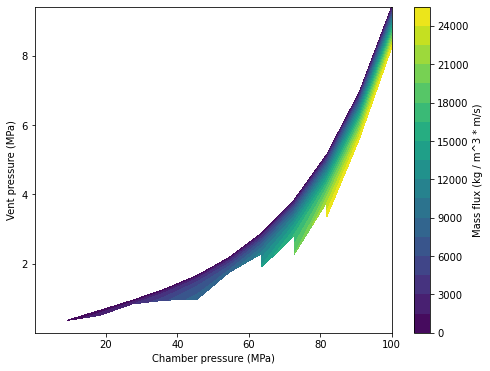

In [82]:
p_final_as_axis = np.zeros_like(mg_p)
for j, p in enumerate(p_sweep):     # Iterate horizontal axis
  for i, j0 in enumerate(j0_sweep): # Iterate vertical axis
    p_final_as_axis[i,j] = outs[i][j][1][0,-1]
mg_j0_as_val = mg_j0.copy()
mg_j0_as_val = np.where(x_final < f.x_mesh[-1], np.nan, mg_j0_as_val)

plt.figure(figsize=(8,6))
plt.contourf(mg_p/1e6, p_final_as_axis/1e6, mg_j0_as_val, levels=20)
plt.xlabel("Chamber pressure (MPa)")
plt.ylabel("Vent pressure (MPa)")
cb = plt.colorbar()
cb.set_label("Mass flux (kg / m^3 * m/s)")

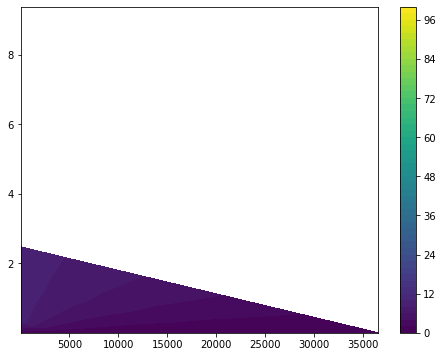

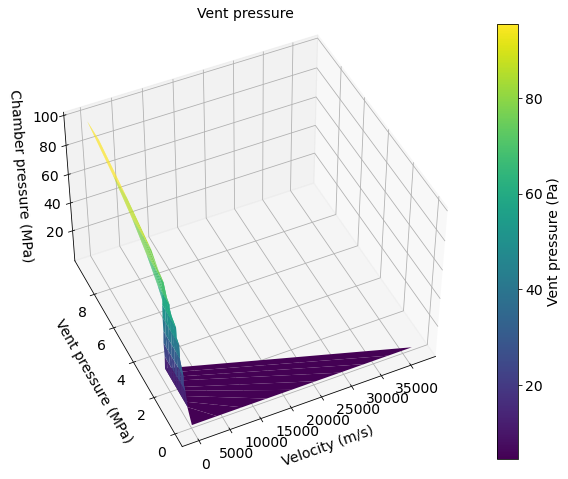

In [23]:
p_final_as_axis = np.zeros_like(mg_p)
for j, p in enumerate(p_sweep):     # Iterate horizontal axis
  for i, j0 in enumerate(j0_sweep): # Iterate vertical axis
    p_final_as_axis[i,j] = outs[i][j][1][0,-1]
mg_j0_as_val = mg_j0.copy()
mg_j0_as_val = np.where(x_final < f.x_mesh[-1], np.nan, mg_j0_as_val)
mg_u = np.zeros_like(mg_p)

for j, p in enumerate(p_sweep):     # Iterate horizontal axis
  for i, j0 in enumerate(j0_sweep): # Iterate vertical axis
    mg_u[i,j] = u_map(p, j0)

plt.figure(figsize=(8,6))
plt.contourf(mg_u, p_final_as_axis/1e6, mg_p/1e6, levels=50)

cb = plt.colorbar()

plt.figure(figsize=(12,8))
ax = plt.axes(projection='3d')
ax.view_init(elev=45, azim=-90-25)
surf = ax.plot_surface(mg_u, p_final_as_axis/1e6, mg_p/1e6, cmap='viridis', edgecolor='none')

ax.set_title('Vent pressure')
ax.set_xlabel("Velocity (m/s)", labelpad=10)
ax.set_ylabel("Vent pressure (MPa)", labelpad=10)
ax.set_zlabel("Chamber pressure (MPa)", labelpad=10)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label,ax.zaxis.label,
              *ax.get_xticklabels(), *ax.get_yticklabels(), *ax.get_zticklabels()]):
  item.set_fontsize(14)
cb = plt.gcf().colorbar(surf)
cb.set_label("Vent pressure (Pa)", fontsize=14)
cb.ax.tick_params(labelsize=14)

plt.show()

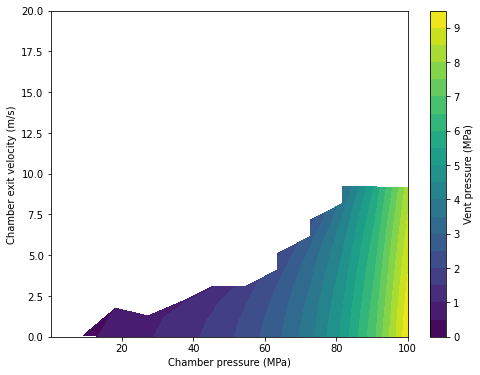

In [25]:
''' Contour plot for j0 mapped to u_chamber '''

p_final = np.zeros_like(mg_p)
mg_u = np.zeros_like(mg_p)
fragdepth = np.zeros_like(mg_p)

for j, p in enumerate(p_sweep):     # Iterate horizontal axis
  for i, j0 in enumerate(j0_sweep): # Iterate vertical axis
    p_final[i,j] = outs[i][j][1][0,-1]
    mg_u[i,j] = u_map(p, j0)

    # Compute fragmentation front depth
    p_soln, h, y = outs[i][j][1]
    phi = f.vf_g(p_soln, f.T_ph(p_soln, h, y), y)
    fragdepth[i,j] = np.interp(f.crit_volfrac, phi, outs[i][j][0])
    
p_final = np.where(x_final < f.x_mesh[-1], np.nan, p_final)

plt.figure(figsize=(8,6))
plt.clf()
plt.contourf(mg_p/1e6, mg_u, p_final/1e6, levels=20)
plt.xlabel("Chamber pressure (MPa)")
plt.ylabel("Chamber exit velocity (m/s)")
plt.ylim(0, 20)
# plt.yscale("log")
cb = plt.colorbar()
cb.set_label("Vent pressure (MPa)")

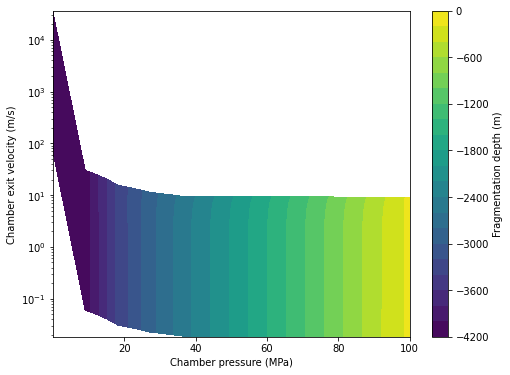

In [15]:
plt.figure(figsize=(8,6))
plt.clf()
plt.contourf(mg_p/1e6, mg_u, fragdepth, levels=20)
plt.xlabel("Chamber pressure (MPa)")
plt.ylabel("Chamber exit velocity (m/s)")
plt.yscale("log")
cb = plt.colorbar()
cb.set_label("Fragmentation depth (m)")

2822.222222222222
Left: line is frag front; middle: line is -9.8*x


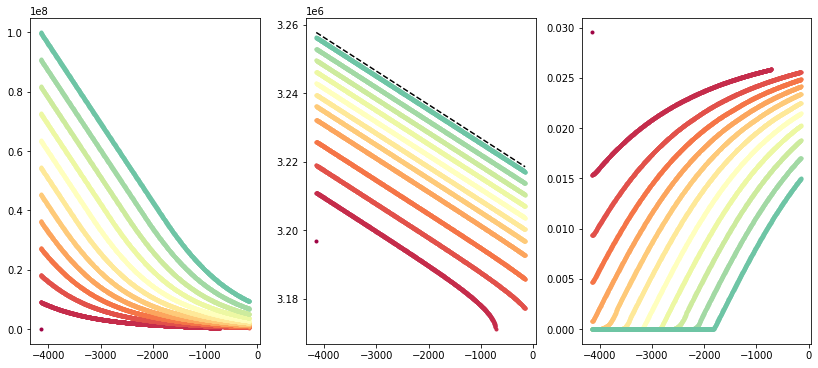

In [91]:
i = 1
print(j0_sweep[i])

plt.figure(figsize=(14,6))
for state_idx in range(3):
  ax = plt.subplot(1,3,state_idx+1)
  ax.set_prop_cycle(color=plt.cm.Spectral(np.linspace(0,1,15)))
  # ax.set_prop_cycle(color=['red','orange','yellow','green','blue','purple'])
  for j in range(0,len(outs[0])): # Iterate over chamber pressures
    plt.plot(outs[i][j][0], outs[i][j][1][state_idx], '.')
    if state_idx == 0:
      # Pressure: also put frag
      # _p_at_frag = outs[i][j][1][0,np.argmin(np.abs(outs[i][j][0] - fragdepth[i,j]))]
      # plt.plot(fragdepth[i,j], _p_at_frag, 'k.')
      pass

plt.subplot(1,3,2)
plt.plot(f.x_mesh, -f.x_mesh*9.8 + outs[i][-1][1][1,:].min(), 'k--')
print("Left: line is frag front; middle: line is -9.8*x")

2822.222222222222
Left: line is frag front; middle: line is -9.8*x


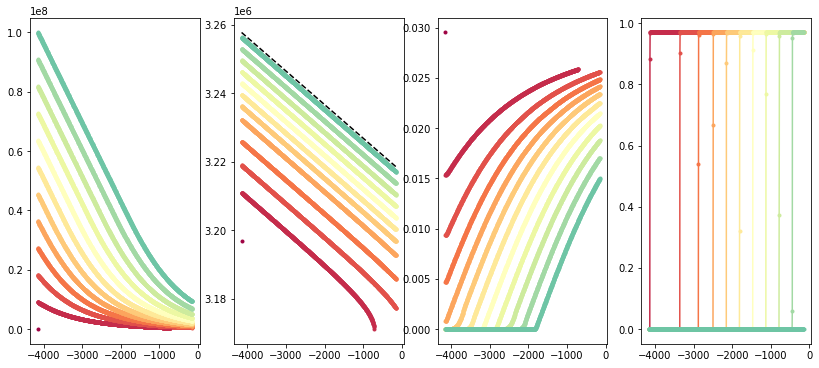

In [94]:
i = 1
print(j0_sweep[i])

plt.figure(figsize=(14,6))
for state_idx in range(4):
  ax = plt.subplot(1,4,state_idx+1)
  ax.set_prop_cycle(color=plt.cm.Spectral(np.linspace(0,1,15)))
  # ax.set_prop_cycle(color=['red','orange','yellow','green','blue','purple'])
  for j in range(0,len(outs[0])): # Iterate over chamber pressures
    plt.plot(outs[i][j][0], outs[i][j][1][state_idx], '.-')
    if state_idx == 0:
      # Pressure: also put frag
      # _p_at_frag = outs[i][j][1][0,np.argmin(np.abs(outs[i][j][0] - fragdepth[i,j]))]
      # plt.plot(fragdepth[i,j], _p_at_frag, 'k.')
      pass

plt.subplot(1,4,2)
plt.plot(f.x_mesh, -f.x_mesh*9.8 + outs[i][-1][1][1,:].min(), 'k--')
print("Left: line is frag front; middle: line is -9.8*x")

In [95]:
''' Eigenvalue and condition number '''
outs[11][-40][1][:,-1]
A_evald = f.A(*outs[11][-40][1][:,-1], j0_sweep[11])
A_symm = 0.5 * (A_evald + A_evald.T)
A_skew = 0.5 * (A_evald - A_evald.T)
A_symm, A_skew, A_evald - A_symm - A_skew
Lambda, X = np.linalg.eig(A_evald)
Lambda = np.diag(Lambda)
np.linalg.cond(Lambda), np.linalg.cond(X), np.linalg.cond(A_evald)

IndexError: list index out of range

# Test zone

In [3]:
import importlib
importlib.reload(ss)

<module 'steady_state' from 'c:\\Users\\fredr\\Documents\\quail_volcano\\src\\physics\\multiphasevpT\\steady_state.py'>

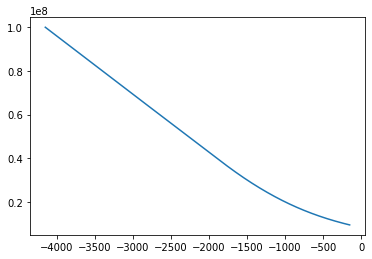

In [71]:
# for k_ in [3,5,7,20]:
q_soln = f.solve_ssIVP(100e6, j0_sweep[1])
q_top = q_soln[1][:,-1]
plt.plot(q_soln[0], q_soln[1][0,:])

In [4]:
q_soln = f.solve_ssIVP(p_sweep[-40], j0_sweep[11])
q_top = q_soln[1][:,-1]
perturbation = np.ones_like(q_top)
F_top = f.F(q_top)
f.F(q_top - 1e-7*perturbation), f.F(q_top), f.F(q_top + 1e-7*perturbation)

(array([[-2.69283512e+03],
        [ 0.00000000e+00],
        [ 1.44850018e-05]]),
 array([[-2.69282364e+03],
        [ 0.00000000e+00],
        [ 1.44750018e-05]]),
 array([[-2.69281217e+03],
        [ 0.00000000e+00],
        [ 1.44650018e-05]]))

RK23
RK45
DOP853
Radau
BDF
Radau


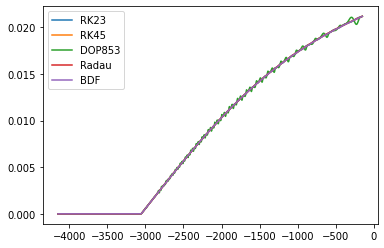

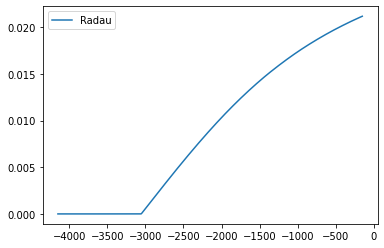

In [5]:
import scipy

# `method` must be one of {'RK23': <class 'scipy.integrate._ivp.rk.RK23'>,
# 'RK45': <class 'scipy.integrate._ivp.rk.RK45'>,
# 'DOP853': <class 'scipy.integrate._ivp.rk.DOP853'>,
# 'Radau': <class 'scipy.integrate._ivp.radau.Radau'>,
# 'BDF': <class 'scipy.integrate._ivp.bdf.BDF'>,
# 'LSODA': <class 'scipy.integrate._ivp.lsoda.LSODA'>} or OdeSolver class.

plt.figure()
def by_method(method):
  soln = scipy.integrate.solve_ivp(*f.ivp_inputs[0:3], t_eval=f.ivp_inputs[3], method=method,
          events=f.ivp_inputs[5])
  print(method)
  plt.plot(soln.t, soln.y[2,:])
methods = ["RK23", "RK45", "DOP853", "Radau", "BDF"]
[by_method(method) for method in methods]
plt.legend(methods)

plt.figure()
[by_method(method) for method in ["Radau"]]
plt.legend(["Radau"])

In [6]:
f.ivp_inputs[2]
# f.yWvInletMin

array([6.72596639e+07, 3.24430021e+06, 1.00000000e-07])

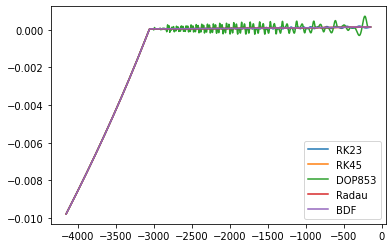

In [7]:
def by_method(method):
  soln = scipy.integrate.solve_ivp(*f.ivp_inputs[0:3], t_eval=f.ivp_inputs[3], method=method,
          events=f.ivp_inputs[5])
  yL = 1.0 - f.yWt - f.yC
  supersaturation = f.yWt - soln.y[2,:] - f.x_sat(soln.y[0,:]) * yL
  plt.plot(soln.t, supersaturation)
methods = ["RK23", "RK45", "DOP853", "Radau", "BDF"]
[by_method(method) for method in methods]
plt.legend(methods)

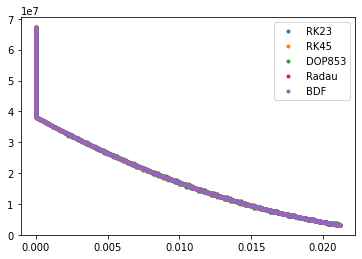

In [8]:
def by_method(method):
  soln = scipy.integrate.solve_ivp(*f.ivp_inputs[0:3], t_eval=f.ivp_inputs[3], method=method,
          events=f.ivp_inputs[5])
  yL = 1.0 - f.yWt - f.yC
  supersaturation = f.yWt - soln.y[2,:] - f.x_sat(soln.y[0,:]) * yL
  plt.plot(soln.y[2,:], soln.y[0,:], '.')
methods = ["RK23", "RK45", "DOP853", "Radau", "BDF"]
[by_method(method) for method in methods]
plt.legend(methods)

In [268]:
np.linalg.solve(A_evald, F_top)

array([[-2.65794413e+04],
       [-9.80023971e+00],
       [ 0.00000000e+00]])

In [237]:
Lambda, X, np.linalg.svd(A_evald)

(array([[ 0.99999996,  0.        ,  0.        ],
        [ 0.        , -1.        ,  0.        ],
        [ 0.        ,  0.        ,  0.4055882 ]]),
 array([[ 9.99999983e-01, -1.05408760e-10, -9.99999964e-01],
        [ 1.84357520e-04,  1.00000000e+00, -2.62320802e-04],
        [ 0.00000000e+00,  0.00000000e+00,  5.68011853e-05]]),
 (array([[-9.99999999e-01,  2.81304185e-12, -3.87574622e-05],
         [-3.36690349e-12, -1.00000000e+00,  1.42904485e-08],
         [-3.87574622e-05,  1.42904486e-08,  9.99999999e-01]]),
  array([1.04647770e+04, 1.00000007e+00, 3.87574580e-05]),
  array([[-9.55586494e-05, -1.94289029e-14, -9.99999995e-01],
         [-3.68715009e-04,  9.99999932e-01,  3.52338891e-08],
         [-9.99999927e-01, -3.68715011e-04,  9.55586429e-05]])))

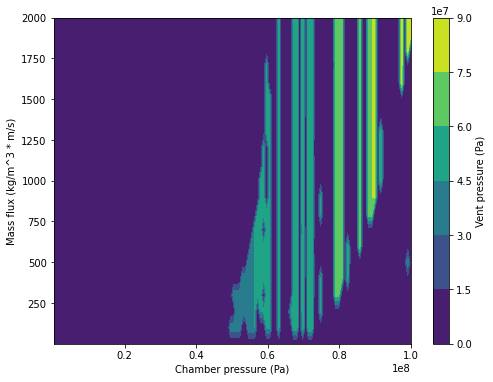

In [155]:
plt.figure(figsize=(8,6))
plt.contourf(mg_p, mg_j0, p_top)
plt.xlabel("Chamber pressure (Pa)")
plt.ylabel("Mass flux (kg/m^3 * m/s)")
cb = plt.colorbar()
cb.set_label("Vent pressure (Pa)")

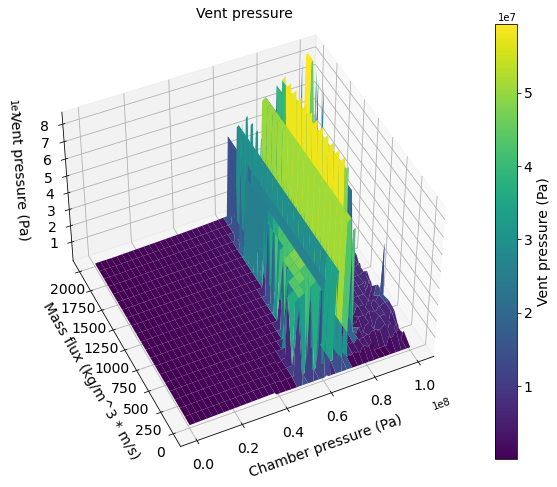

In [156]:
plt.figure(figsize=(12,8))
ax = plt.axes(projection='3d')
ax.view_init(elev=45, azim=-90-25)
surf = ax.plot_surface(mg_p, mg_j0, p_top, cmap='viridis', edgecolor='none')

# plt.xlim((300,1200))
# plt.ylim((0,400))

ax.set_title('Vent pressure')
ax.set_xlabel("Chamber pressure (Pa)", labelpad=10)
ax.set_ylabel("Mass flux (kg/m^3 * m/s)", labelpad=10)
ax.set_zlabel("Vent pressure (Pa)", labelpad=10)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label,ax.zaxis.label,
              *ax.get_xticklabels(), *ax.get_yticklabels(), *ax.get_zticklabels()]):
  item.set_fontsize(14)
cb = plt.gcf().colorbar(surf)
cb.set_label("Vent pressure (Pa)", fontsize=14)
cb.ax.tick_params(labelsize=14)

plt.show()

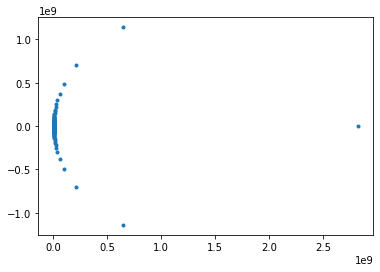

In [127]:
# from scipy.fft import fft, ifft
# plt.plot(fft(outs[i][1][0,:]).real, fft(outs[i][1][0,:]).imag, '.')

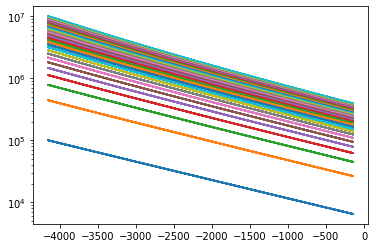

In [121]:
for i, (p, j0) in enumerate(zip(mg_p.ravel(), mg_j0.ravel())):
  plt.semilogy(outs[i][0], outs[i][1][0,:])